<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Projects/Yolo%20V3/Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ls
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


!mkdir -p drive
!google-drive-ocamlfuse drive

import os
os.chdir("drive/Udacity/Yolo/")
!ls

sample_data
E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145480 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0

## Importing Resources

We will start by loading the required packages into Python. We will be using OpenCV to load our images, matplotlib to plot them, autils module that contains some helper functions, and a modified version of Darknet. YOLO uses Darknet, an open source, deep neural network framework written by the creators of YOLO. The version of Darknet used in this notebook has been modified to work in PyTorch 0.4 and has been simplified because we won't be doing any training. Instead, we will be using a set of pre-trained weights that were trained on the Common Objects in Context (COCO) database. For more information on Darknet, please visit [Darknet.](https://pjreddie.com/darknet/)

In [2]:
import cv2
import matplotlib.pyplot as plt

from utils import *
from darknet import Darknet

##Introduction

As you learned in the previous lessons, YOLO is a state-of-the-art, real-time object detection algorithm. In this notebook, we will apply the YOLO algorithm to detect objects in images. We have provided a series of images that you can test the YOLO algorithm on. Below is a list of the available images that you can load:


* cat.jpg
* city_scene.jpg
* dog.jpg
* dog2.jpg
* eagle.jpg
* food.jpg
* giraffe.jpg
* horses.jpg
* motorbike.jpg
* person.jpg
* surf.jpg
* wine.jpg


These images are located in the./images/  folder. We encourage you to test the YOLO algorithm on your own images as well. Have fun!

##Setting Up The Neural Network

We will be using the latest version of YOLO, known as YOLOv3. We have already downloaded the yolov3.cfg file that contains the network architecture used by YOLOv3 and placed it in the /cfg/ folder. Similarly, we have placed the yolov3.weights file that contains the pre-trained weights in the /weights/ directory. Finally, the /data/ directory, contains the coco.names file that has the list of the 80 object classes that the weights were trained to detect.

In the code below, we start by specifying the location of the files that contain the neural network architecture, the pre-trained weights, and the object classes. We then use Darknet to setup the neural network using the network architecture specified in the cfg_file. We then use the.load_weights() method to load our set of pre-trained weights into the model. Finally, we use the load_class_names() function, from the utils module, to load the 80 object classes.

In [3]:
# Set the location and name of the cfg file
cfg_file = './cfg/yolov3.cfg'

# Set the location and name of the pre-trained weights file
weight_file = './weights/yolov3.weights'

# Set the location and name of the COCO object classes file
namesfile = 'data/coco.names'

# Load the network architecture
model = Darknet(cfg_file)

# Load the pre-trained weights
model.load_weights(weight_file)

# Load the COCO object classes
class_names = load_class_names(namesfile)

##Taking a Look at The Neural Network

Now that the neural network has been setup, we can see what it looks like. We can print the network using the .print_network() function.

In [4]:
# Print the neural network used in YOLOv3
model.print_network()

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32
    1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64
    2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32
    3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64
    4 shortcut 1
    5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128
    6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
    7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
    8 shortcut 5
    9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64
   10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128
   11 shortcut 8
   12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256
   13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128
   14 conv    256  3 x 3 / 1    52 x  52 x 128   ->    52 x  52 x 256
   15 shortcut 12
   16 conv    128  1 x 1

As we can see, the neural network used by YOLOv3 consists mainly of convolutional layers, with some shortcut connections and upsample layers. For a full description of this network please refer to the [Yolo V3 Paper](https://pjreddie.com/media/files/papers/YOLOv3.pdf).

## Loading and Resizing Our Images

In the code below, we load our images using OpenCV's cv2.imread() function. Since, this function loads images as BGR we will convert our images to RGB so we can display them with the correct colors.

As we can see in the previous cell, the input size of the first layer of the network is 416 x 416 x 3. Since images have different sizes, we have to resize our images to be compatible with the input size of the first layer in the network. In the code below, we resize our images using OpenCV's cv2.resize() function. We then plot the original and resized images.

In [5]:
from skimage import io

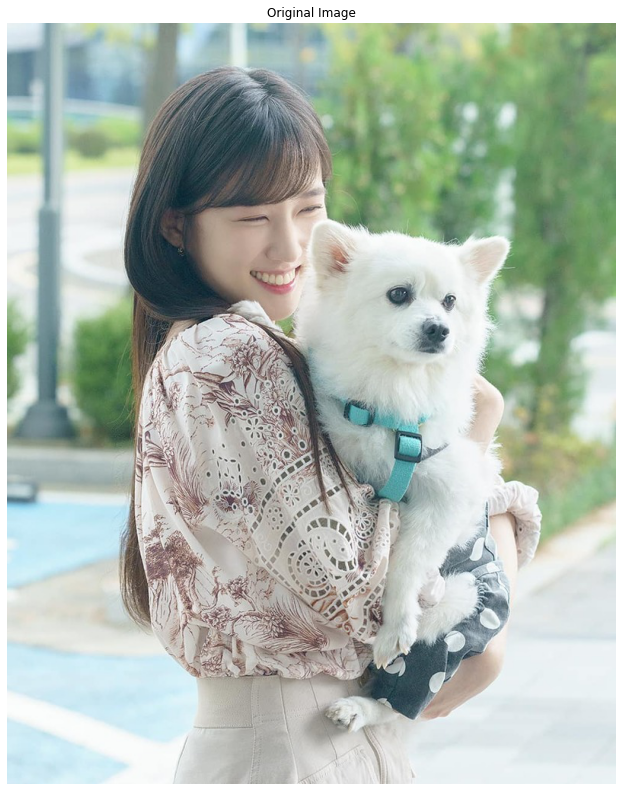

In [7]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]
# Load the image
img_path = 'https://t1.daumcdn.net/news/202010/12/newsen/20201012121607589bubc.jpg'
original_img = io.imread(img_path)
# Display the images
plt.subplot(121)
plt.axis('off')
plt.title('Original Image')
plt.imshow(original_img)
plt.show()

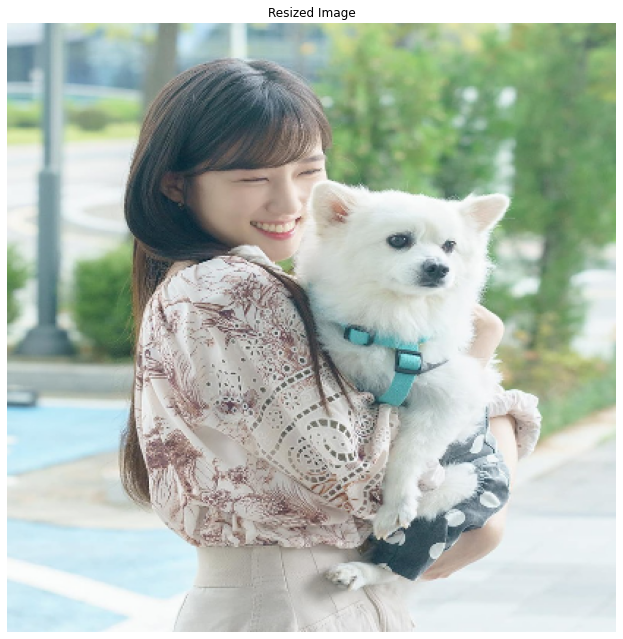

In [8]:
# Set the default figure size
plt.rcParams['figure.figsize'] = [24.0, 14.0]
# We resize the image to the input width and height of the first layer of the network.    
resized_image = cv2.resize(original_img, (model.width, model.height))

# Display the images
plt.subplot(121)
plt.axis('off')
plt.title('Resized Image')
plt.imshow(resized_image)
plt.show()

##Setting the Non-Maximal Suppression Threshold

As you learned in the previous lessons, YOLO uses Non-Maximal Suppression (NMS) to only keep the best bounding box. The first step in NMS is to remove all the predicted bounding boxes that have a detection probability that is less than a given NMS threshold. In the code below, we set this NMS threshold to 0.6. This means that all predicted bounding boxes that have a detection probability less than 0.6 will be removed.

In [9]:
# Set the NMS threshold
nms_thresh = 0.6

##Setting the Intersection Over Union Threshold

After removing all the predicted bounding boxes that have a low detection probability, the second step in NMS, is to select the bounding boxes with the highest detection probability and eliminate all the bounding boxes whose Intersection Over Union (IOU) value is higher than a given IOU threshold. In the code below, we set this IOU threshold to 0.4. This means that all predicted bounding boxes that have an IOU value greater than 0.4 with respect to the best bounding boxes will be removed.

In the utils module you will find the nms function, that performs the second step of Non-Maximal Suppression, and the boxes_iou function that calculates the Intersection over Union of two given bounding boxes. You are encouraged to look at these functions to see how they work.

In [10]:
# Set the IOU threshold
iou_thresh = 0.4

## Object Detection

Once the image has been loaded and resized, and you have chosen your parameters for nms_thresh and iou_thresh, we can use the YOLO algorithm to detect objects in the image. We detect the objects using the detect_objects(m, resized_image, iou_thresh, nms_thresh)function from the utils module. This function takes in the model m returned by Darknet, the resized image, and the NMS and IOU thresholds, and returns the bounding boxes of the objects found.

Each bounding box contains 7 parameters: the coordinates (x, y) of the center of the bounding box, the width w and height h of the bounding box, the confidence detection level, the object class probability, and the object class id. The detect_objects() function also prints out the time it took for the YOLO algorithm to detect the objects in the image and the number of objects detected. Since we are running the algorithm on a CPU it takes about 2 seconds to detect the objects in an image, however, if we were to use a GPU it would run much faster.

Once we have the bounding boxes of the objects found by YOLO, we can print the class of the objects found and their corresponding object class probability. To do this we use the print_objects() function in the utils module.

Finally, we use the plot_boxes() function to plot the bounding boxes and corresponding object class labels found by YOLO in our image. If you set the plot_labels flag to False you will display the bounding boxes with no labels. This makes it easier to view the bounding boxes if your nms_thresh is too low. The plot_boxes()function uses the same color to plot the bounding boxes of the same object class. However, if you want all bounding boxes to be the same color, you can use the color keyword to set the desired color. For example, if you want all the bounding boxes to be red you can use:

plot_boxes(original_image, boxes, class_names, plot_labels = True, color = (1,0,0))

You are encouraged to change the iou_thresh and nms_thresh parameters to see how they affect the YOLO detection algorithm. The default values of iou_thresh = 0.4 and nms_thresh = 0.6 work well to detect objects in different kinds of images. In the cell below, we have repeated some of the code used before in order to prevent you from scrolling up down when you want to change the iou_thresh and nms_threshparameters or the image. Have Fun!

In [11]:
# Detect objects in the image
boxes = detect_objects(model, resized_image, iou_thresh, nms_thresh)



It took 1.638 seconds to detect the objects in the image.

Number of Objects Detected: 2 



In [12]:
# Print the objects found and the confidence level
print_objects(boxes, class_names)

Objects Found and Confidence Level:

1. person: 0.999999
2. dog: 0.998960


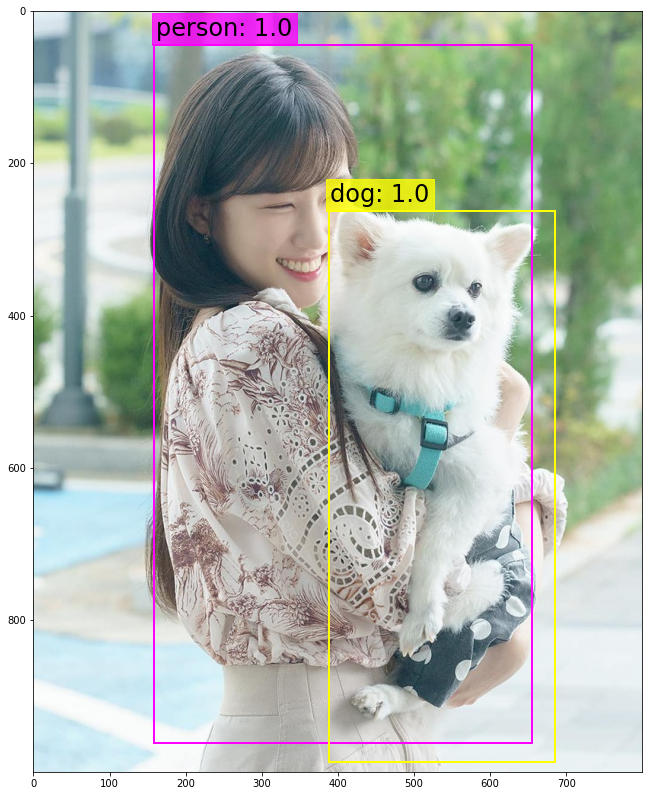

In [13]:
#Plot the image with bounding boxes and corresponding object class labels
plot_boxes(original_img, boxes, class_names, plot_labels = True)

In [14]:
for module in model.modules():
  print(module)

Darknet(
  (models): ModuleList(
    (0): Sequential(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (conv3): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky3): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.